# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from bizdays import Calendar
from matplotlib.ticker import MaxNLocator

cal = Calendar.load("ANBIMA")
maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [3]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [4]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [5]:
data = data[data["mdate"] <= pd.Period("2023-07")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [6]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [7]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [8]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [9]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [10]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [11]:
dias_uteis = 5

copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates = copom_dates[copom_dates['COPOM_date'] >= pd.Period("2001-01-01").to_timestamp()]
copom_dates['COPOM_date'] = cal.offset(copom_dates['COPOM_date'],1)
instrumento = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],dias_uteis),'q':0})
copom_dates = pd.concat([copom_dates, instrumento])
copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")


Drop unnecessary columns

In [12]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [13]:
temp_data = pd.read_pickle("temp.pkl")

In [14]:
copom_dates.sort_values("COPOM_date")

,COPOM_date,q,mdate
54,2001-01-18,1,2001-01
0,2001-01-25,0,2001-01
55,2001-02-15,1,2001-02
1,2001-02-22,0,2001-02
56,2001-03-22,1,2001-03
...,...,...,...
197,2023-02-09,0,2023-02
252,2023-03-23,1,2023-03
198,2023-03-30,0,2023-03
253,2023-05-04,1,2023-05


Merge the two DataFrames on the 'date' column

In [15]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [16]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [17]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2001-01-18,15.9121,-0.1365,2001-01-18,1,2001-01
1,2001-01-25,15.6341,-0.0425,2001-01-25,0,2001-01
2,2001-02-15,15.9326,0.1250,2001-02-15,1,2001-02
3,2001-02-22,16.3953,-0.1453,2001-02-22,0,2001-02
4,2001-03-22,20.8749,2.6645,2001-03-22,1,2001-03


Save the merged DataFrame to a new file

In [18]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [19]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [20]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [21]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [22]:
yield_data.head()

,date,mdate,SVENY01,SVENY02,SVENY05,SVENY10,SVENY30
0,2006-01-02,2006-01,16.603599,16.069818,15.596889,15.433628,15.324786
1,2006-01-03,2006-01,16.594441,16.064808,15.574586,15.404660,15.291373
2,2006-01-04,2006-01,16.567391,15.906773,15.396983,15.316237,15.274382
3,2006-01-05,2006-01,16.564073,15.900342,15.374310,15.317283,15.301432
4,2006-01-06,2006-01,16.537489,15.886892,15.385606,15.376966,15.404397


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [23]:
list_maturities = [str(i).zfill(2) for i in [1,2,5,10,30]]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [24]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY05,SVENY10,SVENY30,SVENY01_d,SVENY02_d,SVENY05_d,SVENY10_d,SVENY30_d
0,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.124902,15.055672,15.021493,-0.158911,-0.089986,-0.040443,-0.130101,-0.259333
1,2006-01-26,16.0298,-0.0181,2006-01-26,0,2006-01,16.025749,15.543076,15.135318,14.995655,14.902546,-0.021838,-0.091229,-0.122664,-0.128821,-0.132913
2,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.436207,14.269266,14.157663,-0.098380,-0.082888,-0.044169,-0.021640,-0.006392
3,2006-03-16,14.9189,0.0371,2006-03-16,0,2006-03,14.920538,14.480900,14.105197,13.943346,13.832876,0.020350,0.001811,0.033137,0.069401,0.095585
4,2006-04-20,14.7318,0.0817,2006-04-20,1,2006-04,14.725141,14.768773,15.041002,15.118933,15.162230,0.085716,0.152560,0.182652,0.157587,0.133680


### Step 1 - 2SLS

In [25]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [26]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.5427
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5410
No. Observations:                 278   F-statistic:                    48.621
Date:                Wed, Sep 20 2023   P-value (F-stat)                0.0000
Time:                        22:05:07   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0018     0.0056    -0.3183     0.7503     -0.0127      0.0092
dgs_d          1.2460     0.1787     6.9729     0.00

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY05,SVENY10,...,SVENY05_d,SVENY10_d,SVENY30_d,const,iv,beta_hat01,beta_hat02,beta_hat05,beta_hat10,beta_hat30
0,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.124902,15.055672,...,-0.040443,-0.130101,-0.259333,1,-0.1546,1.245997,0.93008,0.148372,-0.28075,-0.541951
1,2006-01-26,16.0298,-0.0181,2006-01-26,0,2006-01,16.025749,15.543076,15.135318,14.995655,...,-0.122664,-0.128821,-0.132913,1,0.0181,1.245997,0.93008,0.148372,-0.28075,-0.541951
2,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.436207,14.269266,...,-0.044169,-0.021640,-0.006392,1,-0.0968,1.245997,0.93008,0.148372,-0.28075,-0.541951
3,2006-03-16,14.9189,0.0371,2006-03-16,0,2006-03,14.920538,14.480900,14.105197,13.943346,...,0.033137,0.069401,0.095585,1,-0.0371,1.245997,0.93008,0.148372,-0.28075,-0.541951
4,2006-04-20,14.7318,0.0817,2006-04-20,1,2006-04,14.725141,14.768773,15.041002,15.118933,...,0.182652,0.157587,0.133680,1,0.0817,1.245997,0.93008,0.148372,-0.28075,-0.541951


### Step 2 - Fama and MacBeth

In [27]:
data_complete = data_complete.loc[~mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY01_d"):data_complete.columns.get_loc("SVENY30_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat01"):data_complete.columns.get_loc("beta_hat30") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

In [28]:
data_complete

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY05,SVENY10,...,SVENY10_d,SVENY30_d,const,iv,beta_hat01,beta_hat02,beta_hat05,beta_hat10,beta_hat30,new_shock
0,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.124902,15.055672,...,-0.130101,-0.259333,1,-0.1546,1.245997,0.93008,0.148372,-0.28075,-0.541951,0.039493
2,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.436207,14.269266,...,-0.021640,-0.006392,1,-0.0968,1.245997,0.93008,0.148372,-0.28075,-0.541951,-0.051061
4,2006-04-20,14.7318,0.0817,2006-04-20,1,2006-04,14.725141,14.768773,15.041002,15.118933,...,0.157587,0.133680,1,0.0817,1.245997,0.93008,0.148372,-0.28075,-0.541951,-0.023211
6,2006-06-01,15.4108,-0.1473,2006-06-01,1,2006-06,15.483126,15.980536,16.463595,16.894052,...,-0.202279,-0.047823,1,-0.1473,1.245997,0.93008,0.148372,-0.28075,-0.541951,-0.048725
8,2006-07-20,14.5070,-0.0238,2006-07-20,1,2006-07,14.551159,14.958297,15.602501,16.011988,...,-0.002510,0.001467,1,-0.0238,1.245997,0.93008,0.148372,-0.28075,-0.541951,0.003123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2022-10-27,13.1457,-0.0162,2022-10-27,1,2022-10,13.145766,12.092083,11.834754,12.114741,...,-0.175183,-0.191005,1,-0.0162,1.245997,0.93008,0.148372,-0.28075,-0.541951,0.091152
270,2022-12-08,13.7781,-0.0225,2022-12-08,1,2022-12,13.778129,13.217989,12.854403,13.020333,...,0.131623,0.178051,1,-0.0225,1.245997,0.93008,0.148372,-0.28075,-0.541951,-0.099789
272,2023-02-02,13.5477,0.0871,2023-02-02,1,2023-02,13.547787,13.025719,12.963483,13.137197,...,-0.159004,-0.190562,1,0.0871,1.245997,0.93008,0.148372,-0.28075,-0.541951,0.163828
274,2023-03-23,12.8195,0.1450,2023-03-23,1,2023-03,12.819528,12.148630,12.818525,13.392977,...,0.107957,0.136091,1,0.1450,1.245997,0.93008,0.148372,-0.28075,-0.541951,-0.001866


### Renormalization

In [29]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


In [30]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.441
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                              108.8
Date:                Wed, 20 Sep 2023   Prob (F-statistic):                    3.79e-19
Time:                        22:05:13   Log-Likelihood:                          110.54
No. Observations:                 139   AIC:                                     -219.1
Df Residuals:                     138   BIC:                                     -216.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [31]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2023-06-30")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_complete[['mdate', 'BRW_daily']]

columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')
data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2006-01   0.029693
1    2006-02   0.000000
2    2006-03  -0.038390
3    2006-04  -0.017451
4    2006-05   0.000000
..       ...        ...
205  2023-02   0.123175
206  2023-03  -0.001403
207  2023-04   0.000000
208  2023-05  -0.027159
209  2023-06   0.000000

[210 rows x 2 columns]


C:\Users\Alysson\AppData\Local\Temp\ipykernel_18440\2375401341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')


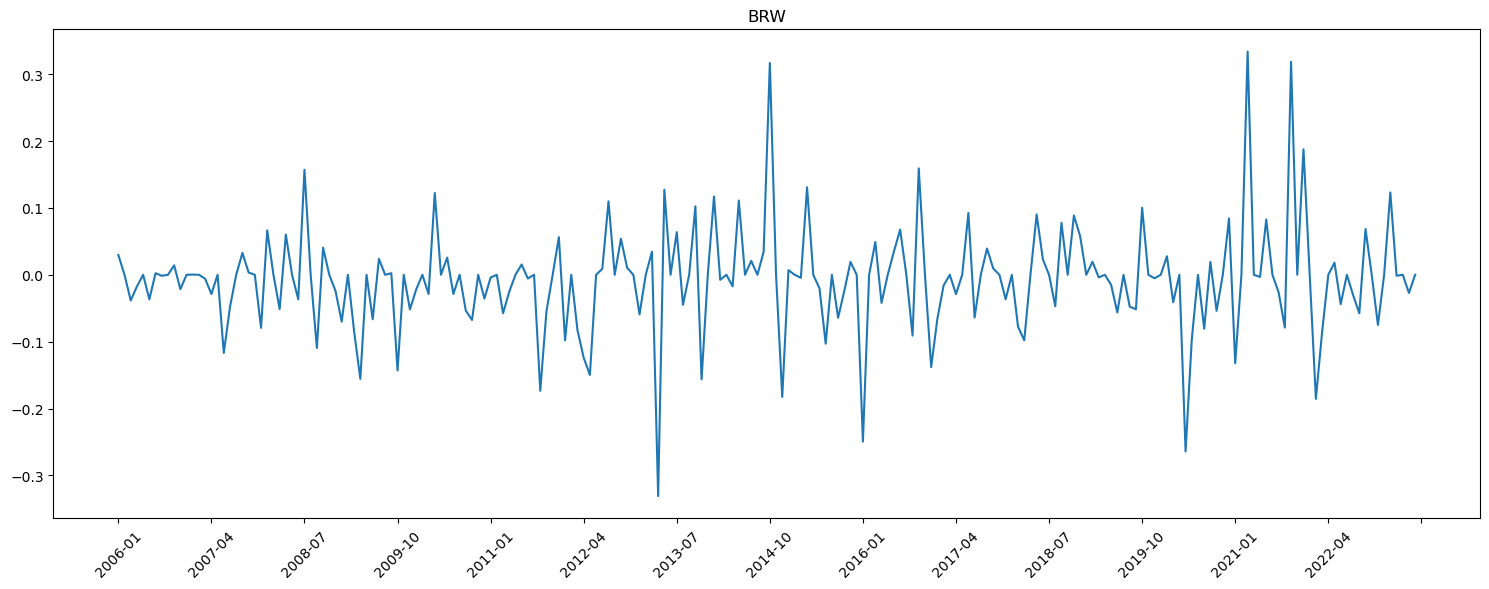

In [32]:
# Converter valores do tipo Period para datetime
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [33]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)

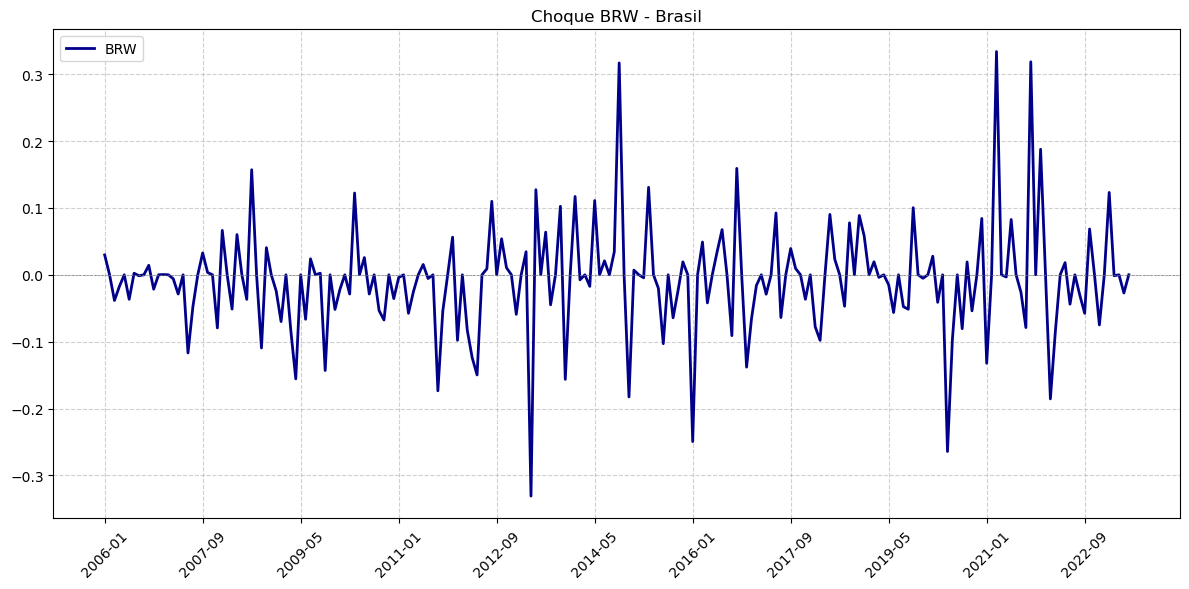

In [34]:

# Seu código para criar os dados (mdate_values, new_shock_values) aqui

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.plot(mdate_values, new_shock_values, color='darkblue', linewidth=2, label='BRW')
plt.title("Choque BRW - Brasil")
#plt.xlabel("Data")
#plt.ylabel("Valor do Choque")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')

# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exibindo o gráfico
plt.show()
